In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
UNIVERSE = "russell_3000"

if UNIVERSE == "russell_3000":
    url = "https://www.kibot.com/Historical_Data/Russell_3000_Historical_Tick_Data.aspx"
    table_index = 1
elif UNIVERSE == "sp500":
    url = "https://stockanalysis.com/list/sp-500-stocks/"
    table_index = 0

ticker_list = pd.read_html(url)[table_index]
filename = f"{UNIVERSE}_historical.csv"

In [3]:
all_data = []

for ticker in ticker_list["Symbol"]:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        historical = stock.history(period="10y")
        historical["Ticker"] = ticker
        historical["Industry"] = info.get("industry")
        historical["Sector"] = info.get("sector")
        historical["MarketCap"] = info.get("marketCap")
        all_data.append(historical)
    except Exception as e:
        print(f"{ticker}: Failed - {e}")

historical_df = pd.concat(all_data)
historical_df = historical_df.reset_index()  # moves Date from index to column
historical_df.to_csv(filename)


$AACC: possibly delisted; no price data found  (period=10y)
$AAN: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$AAWW: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$ABC: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$ABCO: possibly delisted; no price data found  (period=10y)
$ABD: possibly delisted; no price data found  (period=10y)
$ABFS: possibly delisted; no price data found  (period=10y)
$ABH: possibly delisted; no price data found  (period=10y)
$ABMD: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$ABVT: possibly delisted; no price data found  (period=10y)
$ACAS: possibly delisted; no price data found  (period=10y)
$ACC: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$ACE:

DECK: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
DEI: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$DEPO: possibly delisted; no price data found  (period=10y)
$DEST: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$DF: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$DFG: possibly delisted; no price data found  (period=10y)
$DFS: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$DFT: possibly delisted; no price data found  (period=10y)
$DFZ: possibly delisted; no price data found  (period=10y)
$DGI: possibly delisted; no price data found  (period=10y)
$DGIT: possibly delisted; no price data found  (period=10y)
$DHIL: possibly delisted; no price data found  (period=10y)
$DISCA: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$DISCK: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$DISH

PCBC: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$PCCC: possibly delisted; no price data found  (period=10y)
$PCH: possibly delisted; no price data found  (period=10y)
$PCP: possibly delisted; no price data found  (period=10y)
$PCTI: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PCX: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PCYC: possibly delisted; no price data found  (period=10y)
$PDCO: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PDLI: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PEBO: possibly delisted; no price data found  (period=10y)


PEET: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
PEG: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
PEGA: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
PEI: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
PEIX: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$PENN: possibly delisted; no price data found  (period=10y)


PENX: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
PEP: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
PER: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$PETD: possibly delisted; no price data found  (period=10y)
$PETM: possibly delisted; no price data found  (period=10y)
$PFCB: possibly delisted; no price data found  (period=10y)
$PGI: possibly delisted; no price data found  (period=10y)
$PGN: possibly delisted; no price data found  (period=10y)
$PGNX: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PHIIK: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PHX: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PICO: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PIKE: possibly delisted; no price data found  (period=10y)
$PIP: possibly delisted; no price data found  (period=10y)
$PIR: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$PJC

QCOM: Failed - Failed to perform, curl: (28) Operation timed out after 30003 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$QCOR: possibly delisted; no price data found  (period=10y)
$QEP: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$QLGC: possibly delisted; no price data found  (period=10y)
$QLIK: possibly delisted; no price data found  (period=10y)
$QPSA: possibly delisted; no price data found  (period=10y)
$QSFT: possibly delisted; no price data found  (period=10y)
$QSII: possibly delisted; no price data found  (period=10y)
$QTM: possibly delisted; no price data found  (period=10y)
$QTWW: possibly delisted; no price data found  (period=10y)
$RA: possibly delisted; no price data found  (period=10y)


RACK: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$RAD: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$RAH: possibly delisted; no price data found  (period=10y)
$RAI: possibly delisted; no price data found  (period=10y)
$RAS: possibly delisted; no price data found  (period=10y)
$RAVN: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$RAX: possibly delisted; no price data found  (period=10y)
$RCII: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$RCKB: possibly delisted; no price data found  (period=10y)
$RDC: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$RDEA: possibly delisted; no price data found  (period=10y)
$RDEN: possibly delisted; no price data found  (period=10y)
$RDK: possibly delisted; no price data found  (period=10y)
$RDN: possibly delisted; no price data found  (period=10y)
$RE:

RELL: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$REN: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$REV: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$REVU: possibly delisted; no price data found  (period=10y)
$REXI: possibly delisted; no price data found  (period=10y)
$REXX: possibly delisted; no price data found  (period=10y)
$RFMD: possibly delisted; no price data found  (period=10y)
$RHT: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$RIG: possibly delisted; no price data found  (period=10y)
$RIMG: possibly delisted; no price data found  (period=10y)
$RIMM: possibly delisted; no price data found  (period=10y)
$RL: possibly delisted; no price data found  (period=10y)
$RLD: possibly delisted; no price data found  (period=10y)
$RLH: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$RLO

SNSS: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
SNTA: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
SNTS: Failed - Failed to perform, curl: (28) Operation timed out after 30003 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
SNV: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
SNX: Failed - Failed to perform, curl: (28) Recv failure: Connection reset by peer. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
SO: Failed - Failed to perform, curl: (28) Resolving timed out after 30001 milliseconds. See ht

Failed to perform, curl: (16) . See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


SPN: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
SPNC: Failed - Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$SPPI: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$SPRT: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: SPTN"}}}
$SPTN: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$SPW: possibly delisted; no price data found  (period=10y)
$SQI: possibly delisted; no price data found  (period=10y)
$SQNM: possibly delisted; no price data found  (period=10y)
$SREV: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$SRSL: possibly delisted; no price data found  (period=10y)
$SRT: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$SRZ: possibly delisted; no price data found  (period=10

TCAP: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TCB: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$TCBI: possibly delisted; no price data found  (period=10y)


TCBK: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TCI: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TCO: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TCRD: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TDC: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TDG: Failed - Failed to perform, curl: (28) Operation timed out afte

Failed to perform, curl: (16) . See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


TECUA: Failed - Failed to perform, curl: (28) Resolving timed out after 30001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TEG: Failed - Failed to perform, curl: (28) Connection timed out after 30001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TEL: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$TEN: possibly delisted; no price data found  (period=10y)


TER: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TESO: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TEVA: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TEX: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TFM: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TFSL: Failed - Failed to perform, curl: (28) Operation timed out aft

$THG: possibly delisted; no price data found  (period=10y)
$THOR: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$THQI: possibly delisted; no price data found  (period=10y)
$THRX: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$TIBX: possibly delisted; no price data found  (period=10y)
$TICC: possibly delisted; no price data found  (period=10y)
$TIF: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$TIS: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$TIV: possibly delisted; no price data found  (period=10y)
$TIVO: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$TLAB: possibly delisted; no price data found  (period=10y)
$TLEO: possibly delisted; no price data found  (period=10y)
$TMK

TSYS: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TTC: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TTEC: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TTEK: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TTGT: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
TTI: Failed - Failed to perform, curl: (28) Operation timed out af

$TWC: possibly delisted; no price data found  (period=10y)
$TWGP: possibly delisted; no price data found  (period=10y)
$TWTC: possibly delisted; no price data found  (period=10y)
$TWTI: possibly delisted; no price data found  (period=10y)
$TXI: possibly delisted; no price data found  (period=10y)
$TYC: possibly delisted; no price data found  (period=10y)
$TYPE: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$UACL: possibly delisted; no price data found  (period=10y)
$UAM: possibly delisted; no price data found  (period=10y)
$UBA: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$UBNK: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$UBSH: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$UCFC: possibly delisted; no price data found  (period=10y) (

UTHR: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
UTI: Failed - Failed to perform, curl: (28) Operation timed out after 30002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


Failed to perform, curl: (16) . See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


UTIW: Failed - argument of type 'NoneType' is not a container or iterable
UTL: Failed - Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
UTMD: Failed - Failed to perform, curl: (28) Operation timed out after 30003 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$UTX: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VAR: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VASC: possibly delisted; no price data found  (period=10y)
$VCBI: possibly delisted; no price data found  (period=10y)
$VCLK: possibly delisted; no price data found  (period=10y)
$VDSI: possibly delisted; no price data found  (period=10y)
$VGR: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VIAS: possibly delisted; no price data found  (period=10y)
$VICL: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VIVO: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VLCCF: possibly delisted; no price data found  (period=10y)
$VLNC: possibly delisted; no price data found  (period=10y)
$V

VPHM: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$VPRT: possibly delisted; no price data found  (period=10y)
$VQ: possibly delisted; no price data found  (period=10y)
$VRS: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VRTU: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VRX: possibly delisted; no price data found  (period=10y)
$VSCI: possibly delisted; no price data found  (period=10y)
$VSI: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VVI: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$VVTV: possibly delisted; no price data found  (period=10y)
$VVUS: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$WAC: possibly delisted; no price data found  (period=10y)
$WAG: possibly delisted; no price data found  (period=10y)
$WAVX: p

WTM: Failed - Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


$WTR: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$WTSLA: possibly delisted; no price data found  (period=10y)
$WWE: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$WWWW: possibly delisted; no price data found  (period=10y)
$WXS: possibly delisted; no price data found  (period=10y)
$WYN: possibly delisted; no price data found  (period=10y)
$X: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$XCO: possibly delisted; no price data found  (period=10y)
$XEC: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$XL: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$XLNX: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")
$XNPT: possibl

In [14]:
print(f"Tickers: {historical_df['Ticker'].nunique()}")
print(f"Total rows: {len(historical_df)}")

Tickers: 1678
Total rows: 3688692


In [16]:
historical_df = pd.read_csv("sp500_historical.csv")
historical_df = pd.read_csv("russell_3000_historical.csv")

/var/folders/pl/r7xmw3dj49j5xmdjjwtznvcr0000gn/T/ipykernel_81002/2745453140.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  historical_df = pd.read_csv("russell_3000_historical.csv")


In [17]:
# data cleanup
historical_df["Date"] = pd.to_datetime(historical_df["Date"], utc=True) # Standardize format for pandas
dropped_columns = ["Open","High","Low","Volume","Dividends","Stock Splits","Adj Close"]
historical_df = historical_df.drop(dropped_columns, axis=1)

In [18]:
# set up the data for momentum returns
historical_df["YearMonth"] = historical_df["Date"].dt.to_period("M") # standardizes data into monthly format 
monthly_data = historical_df.groupby(["YearMonth", "Ticker"]).last() # drops all other days and just keeps last day of each month.
monthly_data = monthly_data.reset_index()
monthly_data["Return"] = monthly_data.groupby("Ticker")["Close"].pct_change()
monthly_data

/var/folders/pl/r7xmw3dj49j5xmdjjwtznvcr0000gn/T/ipykernel_81002/4037181897.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  historical_df["YearMonth"] = historical_df["Date"].dt.to_period("M") # standardizes data into monthly format


,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Capital Gains,Return
0,2015-11,A,0,2015-11-30 05:00:00+00:00,38.576080,Diagnostics & Research,Healthcare,4.351731e+10,NaN,NaN
1,2015-11,AA,2515,2015-11-30 05:00:00+00:00,21.184233,Aluminum,Basic Materials,1.080916e+10,NaN,NaN
2,2015-11,AAON,5030,2015-11-30 05:00:00+00:00,15.477010,Building Products & Equipment,Industrials,7.631152e+09,NaN,NaN
3,2015-11,AAP,7545,2015-11-30 05:00:00+00:00,143.282639,Auto Parts,Consumer Cyclical,3.113954e+09,NaN,NaN
4,2015-11,AAPL,10060,2015-11-30 05:00:00+00:00,26.672977,Consumer Electronics,Technology,4.138243e+12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
177764,2025-11,YUM,3680012,2025-11-28 05:00:00+00:00,153.210007,Restaurants,Consumer Cyclical,4.253919e+10,NaN,0.108530
177765,2025-11,ZBRA,3682527,2025-11-28 05:00:00+00:00,252.750000,Communication Equipment,Technology,1.280438e+10,NaN,-0.061281
177766,2025-11,ZEUS,3685042,2025-11-28 05:00:00+00:00,38.889999,Steel,Basic Materials,4.354755e+08,NaN,0.051081
177767,2025-11,ZION,3687557,2025-11-28 05:00:00+00:00,53.230000,Banks - Regional,Financial Services,7.858933e+09,NaN,0.030333


In [19]:
# calculate momentum
def calc_momentum(returns):
    growth_factor = 1 + returns # set up returns for compounding
    rolling_return = growth_factor.rolling(11).apply(lambda x: x.prod()) - 1 # for each growth factor, multiply it to the previous 11 months and return the %
    return rolling_return.shift(1) # want the previous 11 months, up to the most recent to avoid recent shocks 

monthly_data["Momentum"] = monthly_data.groupby('Ticker')['Return'].transform(calc_momentum) 
monthly_data.dropna()


,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Capital Gains,Return,Momentum


In [20]:
# for each month, group by deciles
monthly_data["Ranking"] = monthly_data.groupby(["YearMonth"])["Momentum"].rank()


In [21]:
def get_decile_rank(ranking):
    decile_rank = pd.qcut(ranking, q=10, duplicates="drop", labels=False)
    return decile_rank
monthly_data["Decile Ranking"] = monthly_data.groupby("YearMonth")["Ranking"].transform(get_decile_rank)
monthly_data


,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Capital Gains,Return,Momentum,Ranking,Decile Ranking
0,2015-11,A,0,2015-11-30 05:00:00+00:00,38.576080,Diagnostics & Research,Healthcare,4.351731e+10,NaN,NaN,NaN,NaN,NaN
1,2015-11,AA,2515,2015-11-30 05:00:00+00:00,21.184233,Aluminum,Basic Materials,1.080916e+10,NaN,NaN,NaN,NaN,NaN
2,2015-11,AAON,5030,2015-11-30 05:00:00+00:00,15.477010,Building Products & Equipment,Industrials,7.631152e+09,NaN,NaN,NaN,NaN,NaN
3,2015-11,AAP,7545,2015-11-30 05:00:00+00:00,143.282639,Auto Parts,Consumer Cyclical,3.113954e+09,NaN,NaN,NaN,NaN,NaN
4,2015-11,AAPL,10060,2015-11-30 05:00:00+00:00,26.672977,Consumer Electronics,Technology,4.138243e+12,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177764,2025-11,YUM,3680012,2025-11-28 05:00:00+00:00,153.210007,Restaurants,Consumer Cyclical,4.253919e+10,NaN,0.108530,0.014115,885.0,5.0
177765,2025-11,ZBRA,3682527,2025-11-28 05:00:00+00:00,252.750000,Communication Equipment,Technology,1.280438e+10,NaN,-0.061281,-0.338452,196.0,1.0
177766,2025-11,ZEUS,3685042,2025-11-28 05:00:00+00:00,38.889999,Steel,Basic Materials,4.354755e+08,NaN,0.051081,-0.108496,601.0,4.0
177767,2025-11,ZION,3687557,2025-11-28 05:00:00+00:00,53.230000,Banks - Regional,Financial Services,7.858933e+09,NaN,0.030333,-0.117264,577.0,3.0


In [22]:
# Who are most recent winners?
monthly_data[(monthly_data["Decile Ranking"] == 9) & (monthly_data["YearMonth"] == "2016-11")].sort_values("Momentum", ascending=False)

,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Capital Gains,Return,Momentum,Ranking,Decile Ranking
18226,2016-11,GGC,1488152,2016-11-30 05:00:00+00:00,23.875999,None,None,NaN,0.0,24.673117,15.909091,1459.0,9.0
17873,2016-11,CBI,609675,2016-11-30 05:00:00+00:00,0.800000,None,None,NaN,0.0,-0.111111,5.000000,1458.0,9.0
17854,2016-11,CACH,569319,2016-11-30 05:00:00+00:00,0.002500,Apparel Retail,Consumer Cyclical,3.108000e+03,NaN,-0.375000,4.000000,1457.0,9.0
17889,2016-11,CDE,655091,2016-11-30 05:00:00+00:00,9.650000,Gold,Basic Materials,1.109110e+10,NaN,-0.136852,3.367188,1456.0,9.0
18864,2016-11,SIGA,3086626,2016-11-30 05:00:00+00:00,1.918518,Drug Manufacturers - Specialty & Generic,Healthcare,4.339645e+08,NaN,0.174888,2.430769,1455.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18106,2016-11,EPR,1198856,2016-11-30 05:00:00+00:00,40.120697,REIT - Specialty,Real Estate,3.979856e+09,NaN,-0.039294,0.365141,1318.0,9.0
17976,2016-11,CRAI,867804,2016-11-30 05:00:00+00:00,28.797871,Consulting Services,Industrials,1.161039e+09,NaN,0.060022,0.364592,1317.0,9.0
17709,2016-11,AMKR,196954,2016-11-30 05:00:00+00:00,11.037952,Semiconductor Equipment & Materials,Technology,8.995369e+09,NaN,0.275081,0.363235,1316.0,9.0
18569,2016-11,MPX,2341770,2016-11-30 05:00:00+00:00,7.469616,Recreational Vehicles,Consumer Cyclical,2.964418e+08,NaN,0.218431,0.362159,1315.0,9.0


In [23]:
# Who are most recent momentum losers?
monthly_data[(monthly_data["Decile Ranking"] == 0) & (monthly_data["YearMonth"] == "2025-11")].sort_values("Momentum", ascending=True)

,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Capital Gains,Return,Momentum,Ranking,Decile Ranking
176636,2025-11,CYN,974299,2025-11-28 05:00:00+00:00,3.590000,Software - Application,Technology,2.862803e+07,NaN,-0.245798,-0.994413,1.0,0.0
176972,2025-11,ICON,1790454,2025-11-28 05:00:00+00:00,0.798000,Marine Shipping,Industrials,1.779477e+06,NaN,-0.504348,-0.984732,2.0,0.0
176889,2025-11,GTI,1591645,2025-11-28 05:00:00+00:00,2.000000,Other Industrial Metals & Mining,Basic Materials,8.667168e+06,NaN,-0.540230,-0.973048,3.0,0.0
177401,2025-11,PRST,2813733,2025-11-28 05:00:00+00:00,0.000100,Software - Application,Technology,4.185100e+04,NaN,0.000000,-0.958333,4.0,0.0
177202,2025-11,MRGE,2347775,2025-11-28 05:00:00+00:00,0.001000,Oil & Gas Midstream,Energy,5.077140e+05,NaN,-0.500000,-0.950000,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176603,2025-11,CRVL,895867,2025-11-28 05:00:00+00:00,73.180000,Insurance Brokers,Financial Services,3.755067e+09,NaN,-0.010412,-0.392857,146.0,0.0
177150,2025-11,MED,2230358,2025-11-28 05:00:00+00:00,10.970000,Personal Services,Consumer Cyclical,1.205743e+08,NaN,-0.087354,-0.388917,147.0,0.0
177316,2025-11,OKE,2618867,2025-11-28 05:00:00+00:00,72.820000,Oil & Gas Midstream,Energy,4.585883e+10,NaN,0.103835,-0.388714,148.0,0.0
176937,2025-11,HOV,1708890,2025-11-28 05:00:00+00:00,131.580002,Residential Construction,Consumer Cyclical,7.752870e+08,NaN,0.094402,-0.388485,149.0,0.0


In [24]:
# Momentum strategy: all stocks
# Idea: for every month, rank the top momentum winners (Decile 9), and rank the top momentum losers (Decile 0)
# For the upcomming month, go LONG the winners and SHORT the losers
# The following month, track return from portfolio, and rerank stocks.

# Notes: this is all decile 9 and 0 ranks, not accounting for industry bias (we expect semiconductors and tech to outperform the last 10 years, creating concentration to the sector)
# Goal: an alpha of 1%

momentum_df = monthly_data.copy()

momentum_df["Next Month Return"] = momentum_df.groupby("Ticker")["Return"].shift(-1)
winners_df = momentum_df[momentum_df["Decile Ranking"] == 9]
winners_returns = winners_df.groupby("YearMonth")["Next Month Return"].mean()

losers_df = momentum_df[momentum_df["Decile Ranking"] == 0]
losers_returns = losers_df.groupby("YearMonth")["Next Month Return"].mean()  
average_return = winners_returns - losers_returns # subtracting to account for losers' short position.
cumulative_return = (1 + average_return).cumprod()
cumulative_return



YearMonth
2016-11    9.944296e-01
2016-12    9.770004e-01
2017-01   -2.342975e+01
2017-02    2.160386e+03
2017-03    2.117831e+03
               ...     
2025-07    2.608675e+29
2025-08    2.527444e+29
2025-09    8.187567e+27
2025-10    8.279323e+27
2025-11             NaN
Freq: M, Name: Next Month Return, Length: 109, dtype: float64

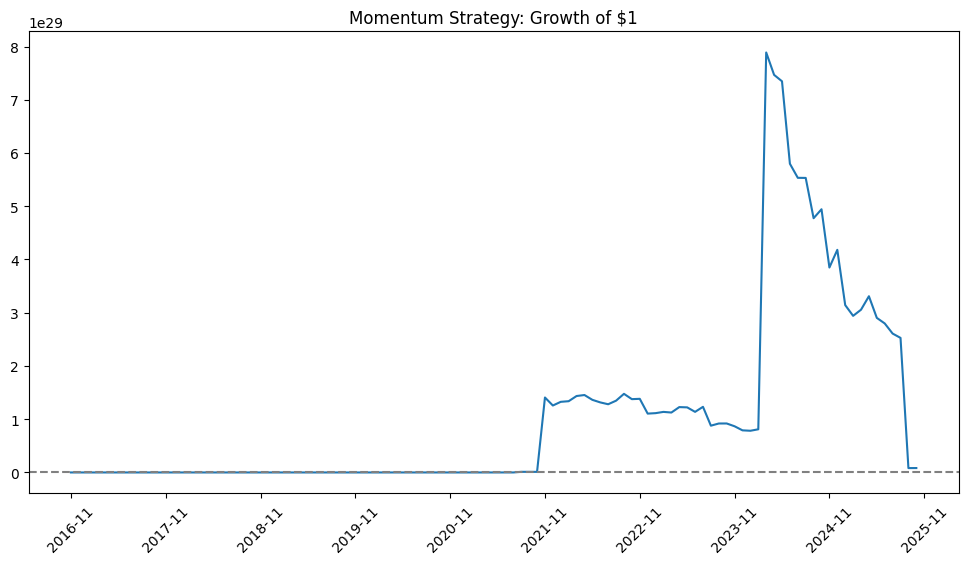

In [25]:
plt.figure(figsize=(12,6))
plt.plot(cumulative_return.index.astype(str), cumulative_return.values)
plt.title("Momentum Strategy: Growth of $1")
plt.axhline(y=1, color='gray', linestyle='--')
plt.xticks(cumulative_return.index.astype(str)[::12],rotation=45)
plt.savefig("SP500_long_short_growth.png")
plt.show()
